In [36]:
import os
import multiprocessing as mp
import numpy as np
import pandas as pd
from scipy.ndimage import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from scout import io
from scout import plot
from scout import utils
from scout.cyto import smooth_segmentation

In [356]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50/dataset/'
os.listdir(working_dir)

['syto.zarr',
 'Ex0_hist.csv',
 'Ex2_hist.csv',
 'nuclei_binary.zarr',
 'nuclei_probability.zarr',
 'nuclei_fluorescence',
 'segment_ventricles.tif',
 'Ex2_rescaled',
 'nuclei_morphologies.csv',
 'syto_down6x',
 'Ex_1_Em_1_stitched',
 'syto_down6x.tif',
 'niche_labels.npy',
 'Ex_0_Em_0_stitched',
 'Ex1_hist.csv',
 'pseudosections.xlsx',
 'Ex_2_Em_2_stitched',
 'cyto_profiles.npy',
 'nuclei_foreground.zarr',
 'celltype_names.csv',
 'centroids.npy',
 'nuclei_gating.npy',
 'cyto_profiles_sample.npy',
 'sox2.zarr',
 'niche_names.csv',
 'voxel_size.csv',
 'mesh_ventricles.pkl',
 'nuclei_segmentations.npz',
 'tbr1.zarr',
 'validation',
 'niche_proximities.npy',
 'Ex0_rescaled',
 'segment_foreground.tif',
 'cyto_sample_index.npy',
 'Ex1_rescaled',
 'centroids_um.npy']

Load cell detections, cell-type labels, ventricle segmentation, and organoid segmentation

In [357]:
centers = np.load(os.path.join(working_dir, 'centroids.npy'))
labels = np.load(os.path.join(working_dir, 'nuclei_gating.npy'))

foreground = io.imread(os.path.join(working_dir, 'segment_foreground.tif'))
ventricles = io.imread(os.path.join(working_dir, 'segment_ventricles.tif'))

centers.shape, labels.shape, foreground.shape, ventricles.shape

((1369040, 3), (1369040, 2), (900, 633, 633), (900, 633, 633))

Get voxel dimensions to be able to refer to physical dimensions

In [358]:
downsample = np.array([1, 6, 6])

voxelsize = utils.read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))
voxelsize_down = voxelsize * downsample

voxelsize, voxelsize_down

((2.0, 0.651, 0.651), array([2.   , 3.906, 3.906]))

Count cells along z-axis to see where which slices are valid

In [359]:
%matplotlib notebook

<IPython.core.display.Javascript object>


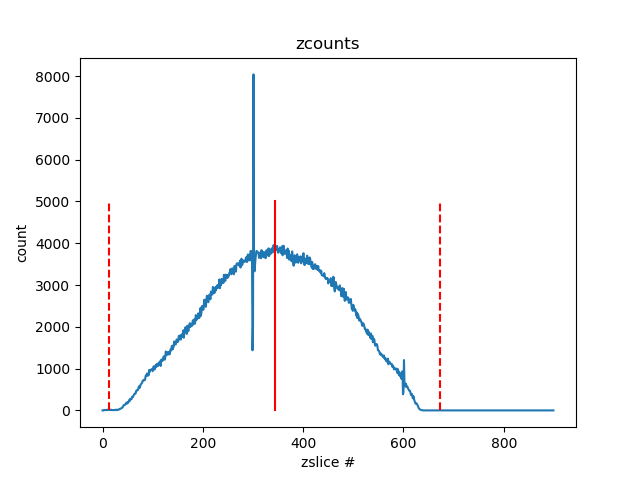

In [365]:
zrange = 330

zcounts = np.bincount(centers[:, 0], minlength=len(foreground))

zmean = (np.arange(len(foreground)) * zcounts).sum() // zcounts.sum()

plt.figure()
sns.lineplot(np.arange(len(foreground)), zcounts)
plt.plot([zmean, zmean],  [0, 5000], 'r-')
plt.plot([zmean-zrange, zmean-zrange],  [0, 5000], 'r--')
plt.plot([zmean+zrange, zmean+zrange],  [0, 5000], 'r--')
plt.xlabel('zslice #')
plt.ylabel('count')
plt.title('zcounts')
plt.show()

<IPython.core.display.Javascript object>


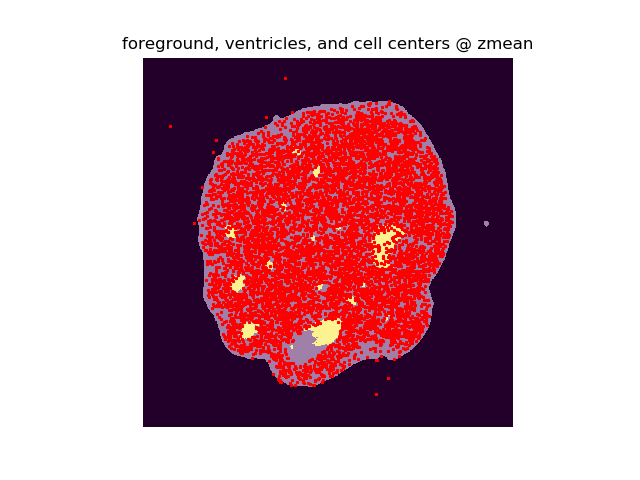

In [366]:
plt.figure()
plot.zprojection(ventricles, centers / downsample, zlim=[zmean-1, zmean+1], markersize=2)
plt.imshow(foreground[zmean], cmap='gray', alpha=0.5)
plt.axis('off')
plt.title('foreground, ventricles, and cell centers @ zmean')
plt.show()

Get SOX2, TBR1, and DN centers

In [367]:
utils.read_csv(os.path.join(working_dir, 'celltype_names.csv'))

['sox2', 'tbr1', 'dn']

In [368]:
centers_sox2 = centers[np.where(labels[:, 0] == 1)]
centers_tbr1 = centers[np.where(labels[:, 1] == 1)]
centers_dn = centers[np.where(np.logical_and(labels[:, 0] == 0, 
                                             labels[:, 1] == 0))]

centers_sox2.shape, centers_tbr1.shape, centers_dn.shape

((504918, 3), (193194, 3), (672892, 3))

In [369]:
ventricles_smooth = smooth_segmentation(ventricles, sigma=2) > 0.5

In [370]:
def pseudoslice(zlim):
    # Get full slice bounds
    zstart = zlim[0]
    zstop = zlim[1]
    start = np.asarray([zstart, 0, 0])
    stop = np.asarray([zstop, *foreground.shape[1:]])

    # Extract cells in full slice
    slice_centers = utils.filter_points_in_box(centers / downsample, start, stop)
    slice_sox2 = utils.filter_points_in_box(centers_sox2 / downsample, start, stop)
    slice_tbr1 = utils.filter_points_in_box(centers_tbr1 / downsample, start, stop)
    slice_dn = utils.filter_points_in_box(centers_dn / downsample, start, stop)

    # Extract segmentations of full slice
    slice_foreground = foreground[zstart:zstop]
    slice_ventricles = ventricles_smooth[zstart:zstop]
    
    slice_data = {
        'centers': slice_centers,
        'centers_sox2': slice_sox2, 
        'centers_tbr1': slice_tbr1,
        'centers_dn': slice_dn,
        'foreground': slice_foreground,
        'ventricles': slice_ventricles,
    }
    
    return slice_data

In [371]:
def measure_pseudoslice(s):
    # Cell frequencies
    freq_sox2 = len(s['centers_sox2']) / len(s['centers'])
    freq_tbr1 = len(s['centers_tbr1']) / len(s['centers'])
    freq_dn = len(s['centers_dn']) / len(s['centers'])

    # Cell densities
    svol = (s['foreground'] > 0).sum() * voxelsize_down.prod() / 1000**3
    density_centers = len(s['centers']) / svol
    density_sox2 = len(s['centers_sox2']) / svol
    density_tbr1 = len(s['centers_sox2']) / svol
    density_dn = len(s['centers_dn']) / svol

    # Ventricle count
    seg = s['ventricles']
    lbl, n_ventricles = label(seg)

    # Ventricle eq. diameter
    regions = regionprops(lbl)
    eqdiams = np.asarray([r.equivalent_diameter for r in regions])
    ave_eqdiam = eqdiams.mean()
    
    measurements = {
        'sox2 frequency': freq_sox2,
        'tbr1 frequency': freq_tbr1,
        'dn frequency': freq_dn,
        'cell density': density_centers,
        'sox2 cell density': density_sox2,
        'tbr1 cell density': density_tbr1,
        'dn cell density': density_dn,
        'ventricle count': n_ventricles,
        'ventricle average diameter': ave_eqdiam
    }
    
    return measurements

Get whole org measurements by taking large pseudoslice

In [372]:
zcenter = zmean
nslices = zrange
zlim = [zcenter-nslices, zcenter+nslices]
# zlim = [0, 650]

s = pseudoslice(zlim)
wholeorg = measure_pseudoslice(s)
wholeorg

{'sox2 frequency': 0.3688312447267401,
 'tbr1 frequency': 0.14112722663968705,
 'dn frequency': 0.4914762205656222,
 'cell density': 632524.7300578959,
 'sox2 cell density': 233294.88350769904,
 'tbr1 cell density': 233294.88350769904,
 'dn cell density': 310870.8637431451,
 'ventricle count': 163,
 'ventricle average diameter': 18.87565108720063}

<IPython.core.display.Javascript object>


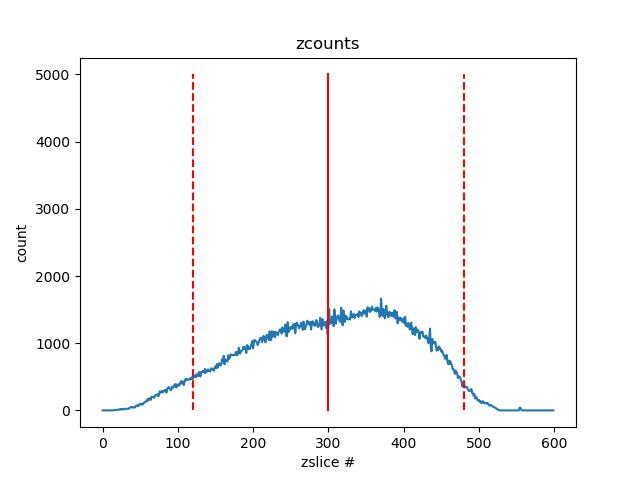

(120, 480)

In [294]:
zrange = 180

zcounts = np.bincount(centers[:, 0], minlength=len(foreground))

zmean = (np.arange(len(foreground)) * zcounts).sum() // zcounts.sum()

plt.figure()
sns.lineplot(np.arange(len(foreground)), zcounts)
plt.plot([zmean, zmean],  [0, 5000], 'r-')
plt.plot([zmean-zrange, zmean-zrange],  [0, 5000], 'r--')
plt.plot([zmean+zrange, zmean+zrange],  [0, 5000], 'r--')
plt.xlabel('zslice #')
plt.ylabel('count')
plt.title('zcounts')
plt.show()

zmin = zmean - zrange
zmax = zmean + zrange

zmin, zmax

In [295]:
def sample_and_measure(zcenter):
    zlim = np.asarray([zcenter - nslices//2, zcenter + nslices//2]).astype(np.int)
    s = pseudoslice(zlim)
    return measure_pseudoslice(s)

In [296]:
thickness = 100  # micron
n_samples = 10000

nslices = thickness // voxelsize_down[0]
zcenters = np.random.randint(zmin + nslices//2, zmax - nslices//2, n_samples)
with mp.Pool(mp.cpu_count()) as pool:
    ms = list(tqdm(pool.imap(sample_and_measure, zcenters), total=len(zcenters)))
df = pd.DataFrame(ms)
df.head()

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.

,cell density,dn cell density,dn frequency,sox2 cell density,sox2 frequency,tbr1 cell density,tbr1 frequency,ventricle average diameter,ventricle count
0,728881.226054,465995.174338,0.639329,152382.007231,0.209063,152382.007231,0.174582,9.383000,5
1,691364.218560,373046.641759,0.539580,230820.525995,0.333862,230820.525995,0.154304,6.962109,14
2,658014.403085,317926.648123,0.483161,243876.849830,0.370625,243876.849830,0.181347,8.320783,11
3,751446.630594,507279.159134,0.675070,167309.639799,0.222650,167309.639799,0.121097,8.768126,7
4,664967.440662,327759.184066,0.492895,242158.240399,0.364166,242158.240399,0.176782,7.759708,12


In [297]:
%matplotlib inline

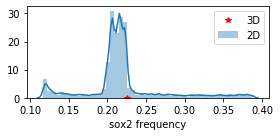

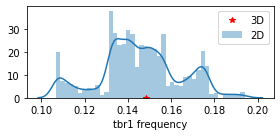

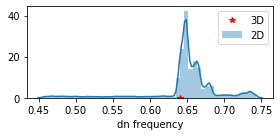

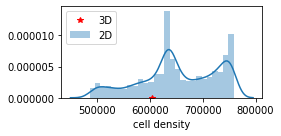

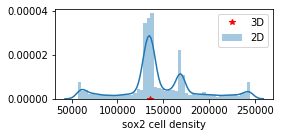

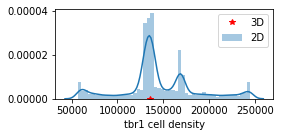

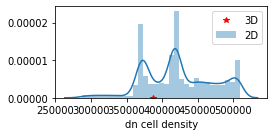

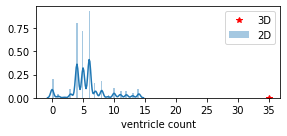

ValueError: cannot convert float NaN to integer

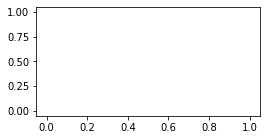

In [298]:
for measurement in list(wholeorg.keys()):
    plt.figure(figsize=(4, 2))
    sns.distplot(df[measurement], label='2D')
    plt.plot([wholeorg[measurement]], [0], 'r*', label='3D')
    plt.xlabel(measurement)
    plt.legend()
    plt.tight_layout()
    plt.show()

We have an estimate of the population variance from this bootstrapped sampling procedure.

For any of the measurements that are not systematically biased, we can estimate the sample size needed
for the mean to be expected to be within 5% of the true mean using the central limit theorem.

$$\hat{\sigma} = \frac{\sigma}{\sqrt{n}} \Rightarrow n = (\frac{\sigma}{\hat{\sigma}})^2$$

We need our expected sample mean to be within 5% of the true sample mean,

$$2 \hat{\sigma} = 0.05 \mu \Rightarrow \hat{\sigma} = 0.025 \mu$$
$$n = \frac{\sigma^2}{(0.025 \mu)^2} $$

In [299]:
measurement = 'tbr1 frequency'

mu = wholeorg[measurement]
sigma = df[measurement].std()
n = sigma**2 / (0.025 * mu)**2
f'Minimum number of slices {np.ceil(n).astype(np.int)} to be within 5%'

'Minimum number of slices 26 to be within 5%'

In [300]:
measurement = 'ventricle average diameter'

mu = wholeorg[measurement]
sigma = df[measurement].std()
n = sigma**2 / (0.025 * mu)**2
f'Minimum number of slices {np.ceil(n).astype(np.int)} to be within 5%'

'Minimum number of slices 124 to be within 5%'

In [301]:
f'Maximum possible slices in zrange: {((zmax-zmin)*voxelsize_down[0] / thickness).astype(np.int)}'

'Maximum possible slices in zrange: 7'

In [302]:
# Save results
df.to_excel(os.path.join(working_dir, 'pseudosections.xlsx'))

In [373]:
df_wholeorg = pd.DataFrame(wholeorg, index=[0])
df_wholeorg.head()

,sox2 frequency,tbr1 frequency,dn frequency,cell density,sox2 cell density,tbr1 cell density,dn cell density,ventricle count,ventricle average diameter
0,0.368831,0.141127,0.491476,632524.730058,233294.883508,233294.883508,310870.863743,163,18.875651


In [374]:
df_wholeorg.to_excel(os.path.join(working_dir, 'pseudosections_wholeorg.xlsx'))

## Aggregate all measurements

In [378]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60'
analysis = pd.read_csv(os.path.join(working_dir, 'analysis.csv'), index_col=0)
analysis.head()

,type
path,
20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60,Lancaster_d35
20190419_15_50_16_AA_org2_488LP13_561LP120_642LP60,Lancaster_d35
20190419_16_09_03_AA_org3_488LP13_561LP120_642LP60,Lancaster_d35
20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50,Lancaster_d35
20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50,Lancaster_d35


In [534]:
dfs = []
dfs_wholeorg = []
for org_idx, path in enumerate(analysis.index):
    folder = analysis['type'].loc[path]
    if folder != 'Lancaster_d35':
        continue
    df = pd.read_excel(os.path.join(working_dir, folder, path, 'dataset/pseudosections.xlsx'), index_col=0)
    df['org_idx'] = len(df) * [org_idx]
    df.index = np.arange(len(df)) + org_idx * len(df)
    df_wholeorg = pd.read_excel(os.path.join(working_dir, folder, path, 'dataset/pseudosections_wholeorg.xlsx'), index_col=0)
    dfs.append(df)
    dfs_wholeorg.append(df_wholeorg)
df = pd.concat(dfs)
df_wholeorg = pd.concat(dfs_wholeorg)

In [535]:
df.head()

,cell density,dn cell density,dn frequency,sox2 cell density,sox2 frequency,tbr1 cell density,tbr1 frequency,ventricle average diameter,ventricle count,org_idx
0,433468.038154,213573.492590,0.492709,164488.929877,0.379472,164488.929877,0.130162,24.964607,13,0
1,476683.309797,282065.057421,0.591724,149881.445129,0.314426,149881.445129,0.096065,23.921478,12,0
2,582954.899385,207452.142311,0.355863,270188.053525,0.463480,270188.053525,0.185324,27.286359,11,0
3,422914.939454,251764.534595,0.595308,131096.455944,0.309983,131096.455944,0.097155,19.413720,15,0
4,497840.602808,226101.605577,0.454165,200479.701991,0.402699,200479.701991,0.145747,24.427417,15,0


In [536]:
df.tail()

,cell density,dn cell density,dn frequency,sox2 cell density,sox2 frequency,tbr1 cell density,tbr1 frequency,ventricle average diameter,ventricle count,org_idx
119995,636134.350551,420750.519822,0.661418,131027.881127,0.205975,131027.881127,0.137285,7.748751,6,11
119996,671115.210132,435439.267519,0.648829,135476.512647,0.201868,135476.512647,0.165008,15.824946,4,11
119997,601897.722814,387936.198769,0.644522,133737.338305,0.222193,133737.338305,0.137031,10.824875,6,11
119998,756584.919716,491075.078780,0.649068,169332.645213,0.223812,169332.645213,0.149790,8.596351,6,11
119999,638689.756857,414448.606856,0.648904,138347.061406,0.216611,138347.061406,0.141938,11.721029,5,11


In [538]:
df_wholeorg.index = np.arange(len(df_wholeorg))
df_wholeorg.head()

,sox2 frequency,tbr1 frequency,dn frequency,cell density,sox2 cell density,tbr1 cell density,dn cell density,ventricle count,ventricle average diameter
0,0.368327,0.136040,0.498623,485870.657423,178959.097766,178959.097766,242266.352119,120,28.449909
1,0.331493,0.146683,0.523010,601332.179074,199337.471514,199337.471514,314502.608527,176,16.917126
2,0.365513,0.134343,0.502481,578017.731753,211273.012167,211273.012167,290443.113137,138,18.039423
3,0.368831,0.141127,0.491476,632524.730058,233294.883508,233294.883508,310870.863743,163,18.875651
4,0.388606,0.164313,0.449809,468837.588351,182193.309872,182193.309872,210887.270557,101,32.951609


Pick out 3 slices, show slice variability in a simple bar chart

In [539]:
slices = df.iloc[12:15].copy()
wholeorg = df_wholeorg.iloc[0].copy()
wholeorg['sample'] = 'Whole org'

df_example = slices

df_example['sample'] = ['Section 1', 'Section 2', 'Section 3']
df_example = df_example.append(wholeorg)
df_example

,cell density,dn cell density,dn frequency,sox2 cell density,sox2 frequency,tbr1 cell density,tbr1 frequency,ventricle average diameter,ventricle count,org_idx,sample
12,577405.545869,222371.355652,0.385122,249358.358884,0.431860,249358.358884,0.188377,24.335352,14.0,0.0,Section 1
13,570762.257355,180056.494839,0.315467,274216.057628,0.480438,274216.057628,0.209373,30.260224,9.0,0.0,Section 2
14,423197.402827,252891.026545,0.597572,130260.935550,0.307802,130260.935550,0.097006,20.556768,14.0,0.0,Section 3
0,485870.657423,242266.352119,0.498623,178959.097766,0.368327,178959.097766,0.136040,28.449909,120.0,NaN,Whole org


In [444]:
%matplotlib inline

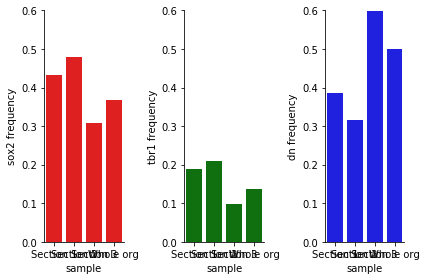

In [590]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 3, 1)
sns.barplot(x='sample', y='sox2 frequency', data=df_example, color='r')
plt.ylim([0, 0.6])
plt.subplot(1, 3, 2)
sns.barplot(x='sample', y='tbr1 frequency', data=df_example, color='g')
plt.ylim([0, 0.6])
plt.subplot(1, 3, 3)
sns.barplot(x='sample', y='dn frequency', data=df_example, color='b')
plt.ylim([0, 0.6])
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join(working_dir, 'example_slices.pdf'), bbox_inches='tight')
plt.show()

SOX2, TBR1, DN freq distributions intraorganoid vs interorganoid

In [496]:
df_wholeorg

,sox2 frequency,tbr1 frequency,dn frequency,cell density,sox2 cell density,tbr1 cell density,dn cell density,ventricle count,ventricle average diameter
0,0.368327,0.136040,0.498623,485870.657423,178959.097766,178959.097766,242266.352119,120,28.449909
1,0.331493,0.146683,0.523010,601332.179074,199337.471514,199337.471514,314502.608527,176,16.917126
2,0.365513,0.134343,0.502481,578017.731753,211273.012167,211273.012167,290443.113137,138,18.039423
3,0.368831,0.141127,0.491476,632524.730058,233294.883508,233294.883508,310870.863743,163,18.875651
4,0.388606,0.164313,0.449809,468837.588351,182193.309872,182193.309872,210887.270557,101,32.951609
5,0.321479,0.124850,0.561990,561138.382581,180394.479241,180394.479241,315354.091652,79,14.375243
6,0.337631,0.119501,0.552296,511030.014265,172539.394498,172539.394498,282240.078729,140,20.896294
7,0.332327,0.098981,0.574139,504469.369820,167648.975837,167648.975837,289635.542481,155,20.084868
8,0.309596,0.115067,0.579242,467431.585289,144715.109308,144715.109308,270756.103152,123,20.424225
9,0.259675,0.133818,0.614110,614727.782969,159629.374730,159629.374730,377510.297650,67,15.381372


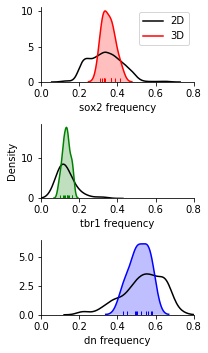

In [613]:
df_wholeorg2 = df_wholeorg.drop([9, 11])
df2 = df#.loc[::1000]

plt.figure(figsize=(3, 5))

plt.subplot(3, 1, 1)
sns.distplot(df2['sox2 frequency'], bins=32, kde_kws={'bw': 0.02, 'shade': False}, hist=False, color='k', label='2D')
sns.distplot(df_wholeorg2['sox2 frequency'], kde_kws={'bw': 0.02, 'shade': True}, hist=False, rug=True, color='r', label='3D')
plt.xlim([0, 0.8])
plt.legend()
# plt.ylabel('Density')

plt.subplot(3, 1, 2)
sns.distplot(df2['tbr1 frequency'], bins=32, kde_kws={'bw': 0.025, 'shade': False}, hist=False, color='k')
sns.distplot(df_wholeorg2['tbr1 frequency'], kde_kws={'bw': 0.010, 'shade': True}, hist=False, rug=True, color='g')
plt.xlim([0, 0.8])
plt.ylabel('Density')

plt.subplot(3, 1, 3)
sns.distplot(df2['dn frequency'], bins=32, kde_kws={'bw': 0.03, 'shade': False}, hist=False, color='k')
sns.distplot(df_wholeorg2['dn frequency'], kde_kws={'bw': 0.03, 'shade': True}, hist=False, rug=True, color='b')
plt.xlim([0, 0.8])
# plt.ylabel('Density')

sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(working_dir, 'pseudoslice_2d_vs_3d_dist.pdf'), bbox_inches='tight')
plt.show()

Use variance ratio to estimate the number of samples needed for slices to match whole org

In [626]:
n = 1

n_sox2 = (df2['sox2 frequency'].std() / (df_wholeorg2['sox2 frequency'].std()/np.sqrt(n)))**2
n_tbr1 = (df2['tbr1 frequency'].std() / (df_wholeorg2['tbr1 frequency'].std()/np.sqrt(n)))**2
n_dn = (df2['dn frequency'].std() / (df_wholeorg2['dn frequency'].std()/np.sqrt(n)))**2

n_sox2, n_tbr1, n_dn

(6.812681848725225, 6.289254362573594, 4.529428217188333)

In [631]:
df_sigma = pd.DataFrame({'celltype': 2 * ['SOX2', 'TBR1', 'DN'],
                         'sigma': [
                                  df_wholeorg2['sox2 frequency'].std(), 
                                  df_wholeorg2['tbr1 frequency'].std(), 
                                  df_wholeorg2['dn frequency'].std(),
                                  df2['sox2 frequency'].std(), 
                                  df2['tbr1 frequency'].std(), 
                                  df2['dn frequency'].std()
                         ],
                         'type': 3 * ['3D'] + 3 * ['2D']})
df_sigma

,celltype,sigma,type
0,SOX2,0.033142,3D
1,TBR1,0.020693,3D
2,DN,0.051433,3D
3,SOX2,0.086505,2D
4,TBR1,0.051895,2D
5,DN,0.109463,2D


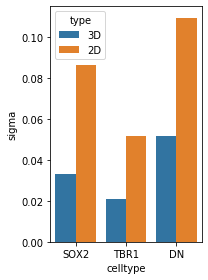

In [637]:
plt.figure(figsize=(3, 4))
sns.barplot(x='celltype', y='sigma', hue='type', data=df_sigma)
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'pseudoslice_2d_vs_3d_sigma.pdf'), bbox_inches='tight')
plt.show()